In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FRED_API_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_percentage_error




fred = fr.Fred(api_key=fred_api_key)



YENUSD = fred.get_series("DEXJPUS")
YENUSD.name = "YENUSD"

df = pd.concat([YENUSD],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)





device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


cuda:0


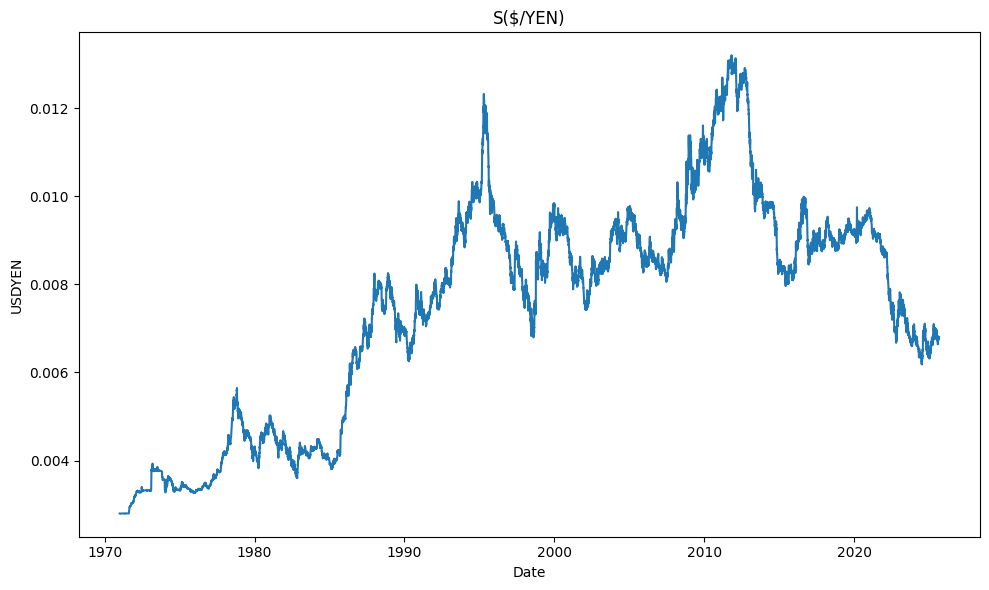

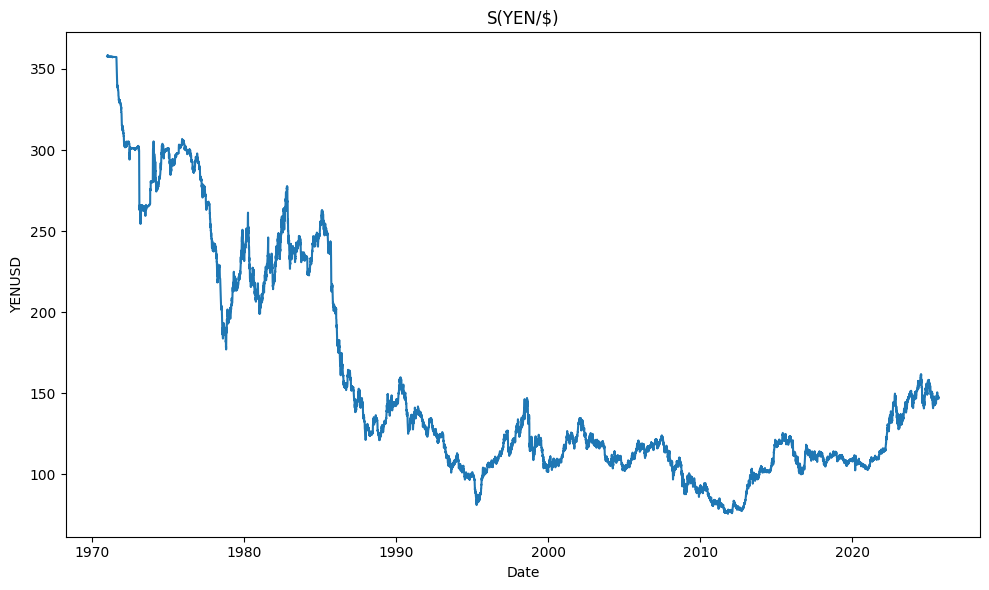

In [2]:

df['USDYEN']  = 1 / df['YENUSD']

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y="USDYEN",data=df)
plt.title("S($/YEN)")
plt.savefig("images/spot-rate-USD-YEN.png")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y="YENUSD",data=df)
plt.title("S(YEN/$)")
plt.savefig("images/spot-rate-YEN-USD.png")
plt.tight_layout()
plt.show()

In [3]:

df.drop("YENUSD",inplace=True,axis=1)
df.drop_duplicates(inplace=True)

training = df.iloc[:,1:2].values
train_size = int(len(training) * .90)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, X):
        h0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        c0 = torch.zeros(2 * self.num_layers, X.size(0), self.hidden_size)
        out, _ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = BiLSTM(input_size=1,hidden_size=256,num_layers=1,output_size=1)
epochs = 500
learning_rate = 0.001
bilistm_optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()


for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    bilistm_optimizer.zero_grad()
    loss.backward()
    bilistm_optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')



/tmp/ipykernel_114923/1209853664.py:83: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_114923/1209853664.py:85: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4671; Test RSME: 0.4415
Epoch: 1; train_RSEM: 0.4548; Test RSME: 0.4279
Epoch: 2; train_RSEM: 0.4426; Test RSME: 0.4142
Epoch: 3; train_RSEM: 0.4304; Test RSME: 0.4004
Epoch: 4; train_RSEM: 0.4182; Test RSME: 0.3866
Epoch: 5; train_RSEM: 0.406; Test RSME: 0.3727
Epoch: 6; train_RSEM: 0.3939; Test RSME: 0.3586
Epoch: 7; train_RSEM: 0.3817; Test RSME: 0.3445
Epoch: 8; train_RSEM: 0.3696; Test RSME: 0.3302
Epoch: 9; train_RSEM: 0.3574; Test RSME: 0.3157
Epoch: 10; train_RSEM: 0.3453; Test RSME: 0.301
Epoch: 11; train_RSEM: 0.3332; Test RSME: 0.2862
Epoch: 12; train_RSEM: 0.3212; Test RSME: 0.2711
Epoch: 13; train_RSEM: 0.3093; Test RSME: 0.2559
Epoch: 14; train_RSEM: 0.2975; Test RSME: 0.2406
Epoch: 15; train_RSEM: 0.286; Test RSME: 0.2252
Epoch: 16; train_RSEM: 0.2749; Test RSME: 0.2097
Epoch: 17; train_RSEM: 0.2642; Test RSME: 0.1943
Epoch: 18; train_RSEM: 0.2541; Test RSME: 0.1791
Epoch: 19; train_RSEM: 0.2447; Test RSME: 0.1642
Epoch: 20; train_RSEM: 0.2361; Te

In [4]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)


# Root-Mean Squared Error
rmse = root_mean_squared_error(y_test_np,pred_np)
print(f"Root Mean Squared Error: {rmse:.4f}")

# R2 Score
r2 = r2_score(y_test,pred_np)
print(f'R2 Score: {r2*100:.2f}')


# root mean average 
mape = mean_absolute_percentage_error(y_test_np,pred_np)
print(f'Mean Average Percentage Error: {mape:.4}')


test_dates = df.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

Root Mean Squared Error: 0.0053
R2 Score: 99.77
Mean Average Percentage Error: 0.008967
         Date  Actual Spot Rate  Predicted Spot Rate
0  2020-03-10          0.009642             0.009752
1  2020-03-11          0.009541             0.009637
2  2020-03-12          0.009463             0.009533
3  2020-03-13          0.009333             0.009453
4  2020-03-16          0.009466             0.009319
5  2020-03-17          0.009310             0.009456
6  2020-03-18          0.009221             0.009296
7  2020-03-19          0.009084             0.009205
8  2020-03-20          0.008985             0.009065
9  2020-03-23          0.008980             0.008964
10 2020-03-24          0.008973             0.008959
11 2020-03-25          0.008974             0.008952
12 2020-03-26          0.009137             0.008953
13 2020-03-27          0.009246             0.009119
14 2020-03-30          0.009254             0.009230
15 2020-03-31          0.009300             0.009239
16 2020-04-

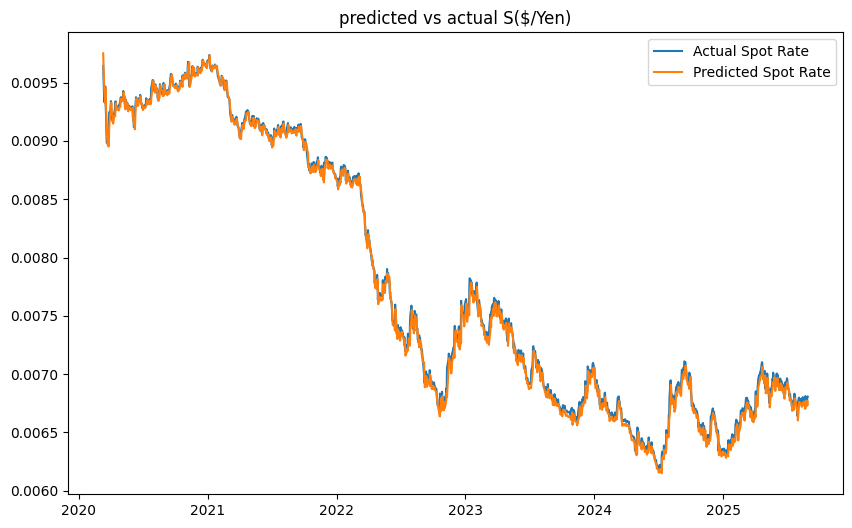

In [5]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.title("predicted vs actual S($/Yen)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate_usdjpn.png")
plt.show()